## Imports

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Class

In [91]:
class value():
    def __init__(self, data, _children = (), _op = None, label = ''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.grad = 0
        self.label = label

    def __repr__(self):
        return  f" Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other)  
        out = value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward

        return out

    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)  
        out = value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t =  np.tanh(x)
        out = value(t, (self,), 'tanh'); out.label = 'out'
        def _backward():
            self.grad = (1 - (t **2)) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = [] 
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()

## Graph

In [69]:
import graphviz  
from IPython.display import display, SVG

def get_nodes_edges(root):
    # build a set upt with all the nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
    ps = graphviz.Digraph(format = 'svg', graph_attr = {'rankdir' : 'LR'} )
    
    nodes, edges = get_nodes_edges(root)

    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangle with the data of the value
        ps.node(uid, label = "{%s | data %.3f | grad %.3f}" % (n.label, n.data, n.grad), shape = 'record') 
        
        if n._op:
            #if this value is a result of an operation, create a circle with the operation
            ps.node(name =uid + n._op, label = n._op)
            #create an edge between the value and the operation
            ps.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect the nodes
        ps.edge(str(id(n1)), str(id(n2)) + n2._op )

    svg_data = ps.pipe(format='svg')
    display(SVG(svg_data))

In [86]:
class Neuron():
    def __init__(self, x1, x2):
        self.x1 = x1; x1.label = 'x1'
        self.x2 = x2; x2.label = 'x2'
        self.w1 = value(np.random.uniform(0,1)); self.w1.label = 'w1'
        self.w2 = value(np.random.uniform(0,1)); self.w2.label = 'w2'
        self.b = value(0); self.b.label = 'b'

    def __repr__(self):
        return f"Neuron(w1={self.w1}, w2={self.w2}, b={self.b})"
    
    def output(self):
        x1w1 = self.x1 * self.w1; x1w1.label = 'x1*w1'
        x2w2 = self.x2 * self.w2; x2w2.label = 'x2*w2'
        x1w1x2w2 = x1w1 * x2w2; x1w1x2w2.label = 'x1w1*x2w2'
        output = x1w1x2w2 + self.b; output.label = 'x1w1*x2w2+b'
        return output

x1 = value(2)
x2 = value(3)
n = Neuron(x1,x2)

n = n.output()
out = n.tanh()

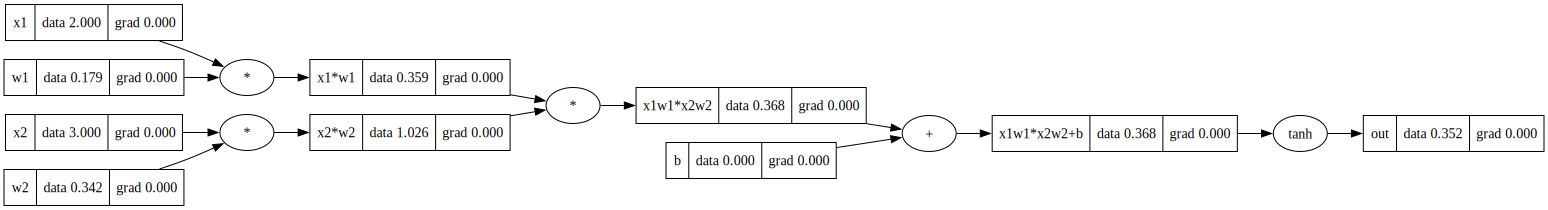

In [88]:
draw_graph(out)

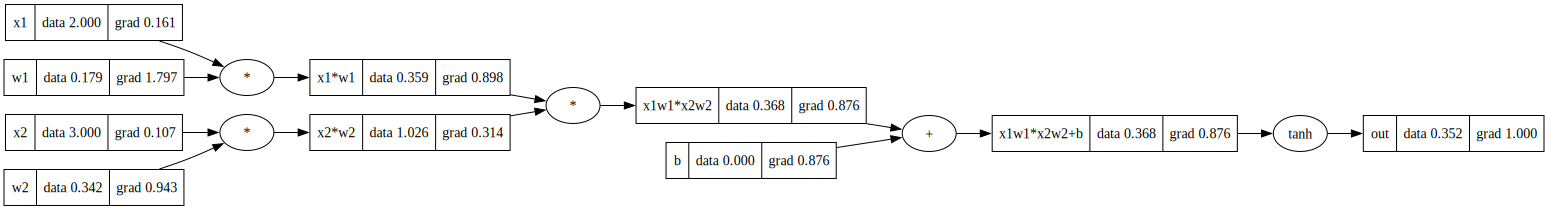

In [90]:
out.backward()
draw_graph(out)
